# Physics 113 Final Project
Lucas Pauker

## Outline

- Goal
- Setup
- Discrete Fourier Transform
- Short-Time Fourier Transform
- Music Primer
- Constant-Q Transform
- Note Onset Detection
- Music Notation
- Play Score
- Polyphonic Music Transcription

## Goal

The goal of this project is to automatically transcribe an audio file into musical notation.
This task is called automatic music transcription, which is a topic that has been researched since the 1970s.
Automatic music transcription is a challenging task that consists of many subtasks, such as pitch estimation, note onset detection, beat tracking, and score typesetting.
Automatic music transcription is useful for music education, music creation, music production, and music analysis.
Many signal processing techniques as well as more recently machine learning techniques have been used to tackle this problem.

I am personally interested in this project because I like listening to and playing music.
In my experience, music transcription is a long and arduous process, so I was curious to see if it would be possible to accurately automate.
This notebook will be structured in a way that incrementally introduces concepts to get to the finished final product.

References:
- https://www.eecs.qmul.ac.uk/~simond/pub/2018/BenetosDixonDuanEwert-SPM2018-Transcription.pdf
- https://github.com/GuitarsAI/BasicAutoTranscriptionRepo

## Setup

In [1]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy
from scipy.fftpack import fft, fftfreq
from scipy.signal import stft, spectrogram
from scipy.io import wavfile
import numpy as np
import librosa
import librosa.display
import abjad
import music21
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
filename = "./sound_files/sweet_child_of_mine.wav"
sampling_freq, data = wavfile.read(filename)
print ("# channels: ", len(data.shape))
print ("sampling freq: ", sampling_freq)
if len(data.shape) == 2:
    data = data.sum(axis=1) / 2
n_seconds = 10
data = data[:sampling_freq * n_seconds]

# channels:  2
sampling freq:  48000


In [3]:
ipd.Audio(data, rate=sampling_freq)

In [4]:
N = len(data)
print("N:", N)
secs = N / sampling_freq
print("secs:", secs)
t_step = 1.0 / sampling_freq  # time between samples in seconds
print ("timestep between samples:", t_step)

N: 480000
secs: 10.0
timestep between samples: 2.0833333333333333e-05


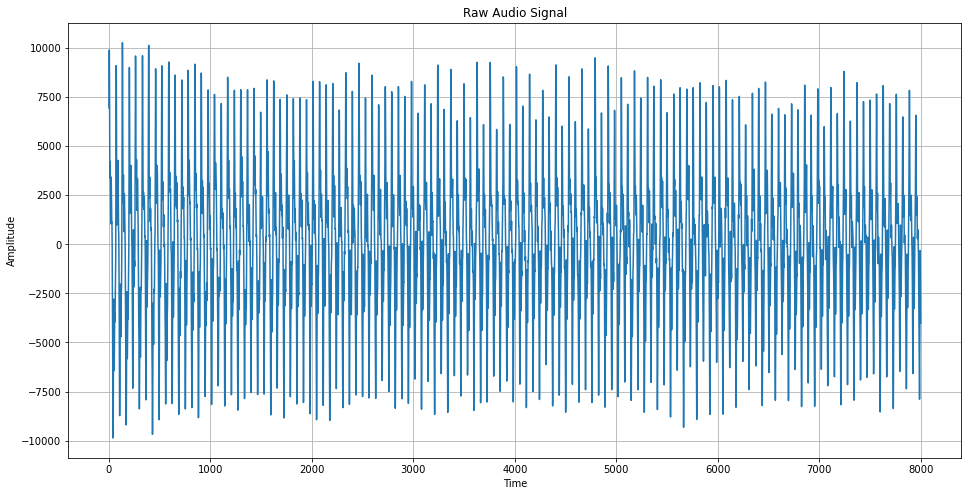

In [5]:
plt.plot(data[9*48000:10*48000-40000])
plt.title("Raw Audio Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

## Discrete Fourier Transform

The first step for automatic music transcription is to extract the pitches from a song.
In order to do this, we need to use the discrete Fourier transform (DFT).
Let our signal be defined as a sequence of $N$ samples $x_0,x_1,...,x_{N-1}$.
We define the DFT as:
\begin{equation}
    X(k)=\sum_{t=0}^{N-1} x_t \cdot e^{-\frac{2\pi i}{N} k t},
\end{equation}
where $X(k)$ is the output, and $0\leq k\leq N-1$.

We can see that this is a natural discretization of the Fourier transform,
\begin{equation}
    F(k)=\int_{-\infty}^{\infty} f(t)\cdot e^{-2\pi i k t} dt.
\end{equation}

Furthermore, the coefficients for the Fourier tranform of a function that is nonzero in the interval $[0, $N$]$ is:
\begin{equation}
    c_k=\frac{1}{N}\int_0^{N}f(t)\cdot e^{-\frac{2\pi i}{N} k t} dt,
\end{equation}
which is identical to the DFT equation up to a scaling factor (and the discretization).

References:
- http://musicweb.ucsd.edu/~trsmyth/digitalAudio/digitalAudio.pdf
- https://en.wikipedia.org/wiki/Discrete_Fourier_transform

If we apply the discrete Fourier transform to the raw audio signal, we get the following plot:

In [6]:
fft_out = np.abs(fft(data))
fft_out_side = fft_out[:int(N/2)]
freqs = fftfreq(N, t_step)
freqs_side = freqs[:int(N/2)]
fft_out[:10]

array([ 59063.5       ,  74585.33687456,  87566.08298951, 165521.6473626 ,
       206175.7230345 , 146508.75413841,  87728.98825751, 172439.10759031,
       115109.45178864, 127560.34282906])

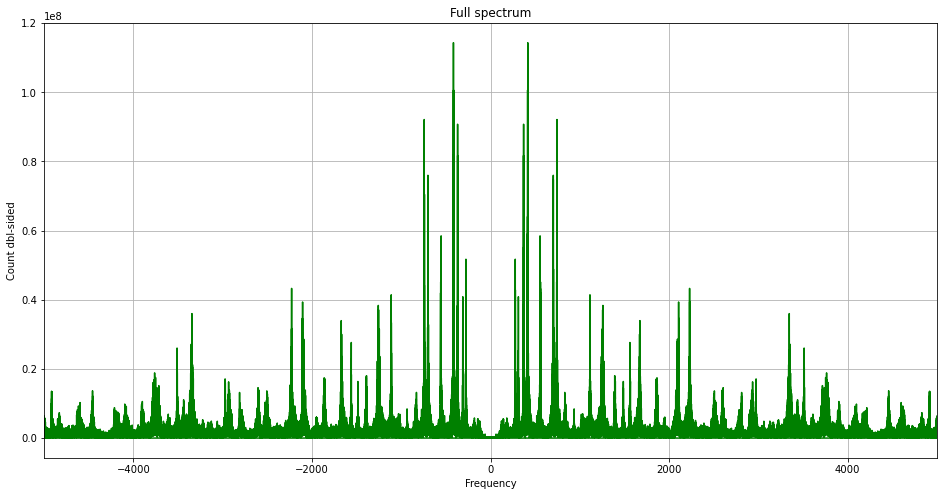

In [7]:
plt.plot(freqs, fft_out, "g")
plt.xlim([-5000, 5000])
plt.title("Full spectrum")
plt.xlabel("Frequency")
plt.ylabel("Count dbl-sided")
plt.grid()
plt.show()

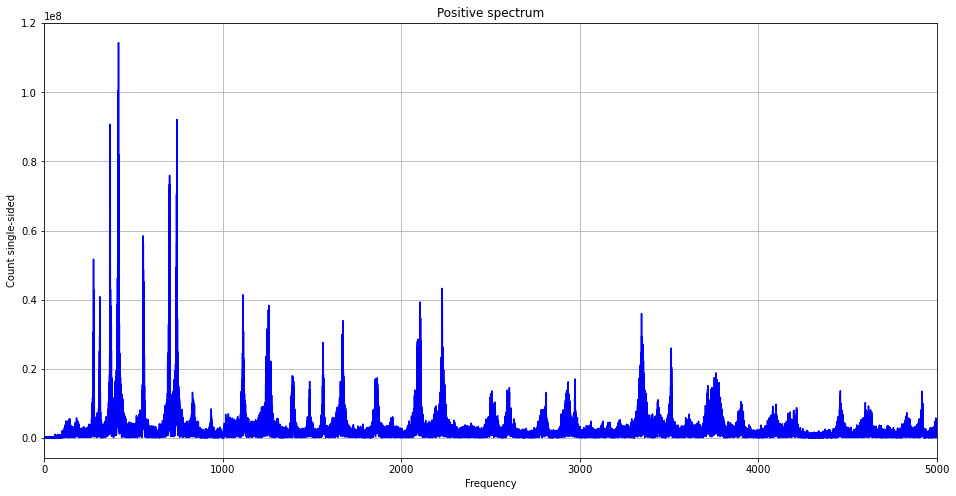

In [8]:
plt.plot(freqs_side, fft_out_side, "b")
plt.xlim([0, 5000])
plt.title("Positive spectrum")
plt.xlabel("Frequency")
plt.ylabel("Count single-sided")
plt.grid()
plt.show()

We can see that the signal contains many frequencies.
This plot is not very useful for automatic transcription.
The question then is: how can we parse these frequencies over time?

## Short-time Fourier Transform

The solution to this problem of finding frequencies over time is to use the short-time Fourier Transform (STFT).
For the STFT, the data to be transformed is broken up into chunks that usually overlap each other.
Each chunk is then Fourier transformed.
Furthermore, each chunk is multiplied by a window function.
Therefore, the output of the STFT is two dimensional since the Fourier transform is applied at many intervals throughout the signal.

Formally, the STFT is defined as,
\begin{equation}
    X(k, m)=\sum_{t=0}^{N-1} x_{t} \cdot w(t-m) \cdot e^{-\frac{2\pi i}{N} k t},
\end{equation}
where $X(k, m)$ is the output, $0\leq k\leq N-1$ and $0\leq m\leq N-1$.
Also, $w$ is the window function that must be defined for the domain $[-N+1, N-1]$.

The following image is a diagram of the STFT.
Note the Gaussian-shaped window function.

<img src="pictures/stft.jpg" alt="STFT image" width="400"/>

References:
- https://en.wikipedia.org/wiki/Short-time_Fourier_transform
- https://www.sciencedirect.com/book/9780123744906/digital-signal-processing-system-design
- http://faculty.nps.edu/rcristi/eo3404/b-discrete-fourier-transform/text/3-stft.pdf

For the STFT, we can try different window functions. Two window functions we will consider are boxcar and hann. 

In [9]:
fft_window_len = 1024
overlap = 0.5
hop_length = int(fft_window_len * (1 - overlap))
ylims = [librosa.note_to_hz("B1"), librosa.note_to_hz("B7")]
n_bins=100

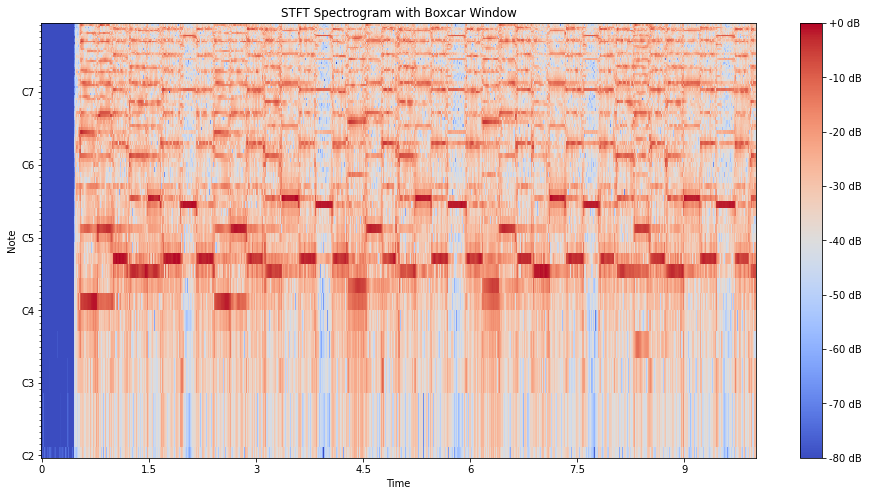

In [10]:
S = librosa.stft(data, n_fft=fft_window_len, hop_length=hop_length, window=scipy.signal.windows.boxcar)
Sdb = librosa.amplitude_to_db(np.abs(S), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(Sdb, sr=sampling_freq, hop_length=hop_length,
                               x_axis="time", y_axis="fft_note", ax=ax, cmap="coolwarm")
ax.set_title("STFT Spectrogram with Boxcar Window")
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.ylim(ylims)
plt.show()

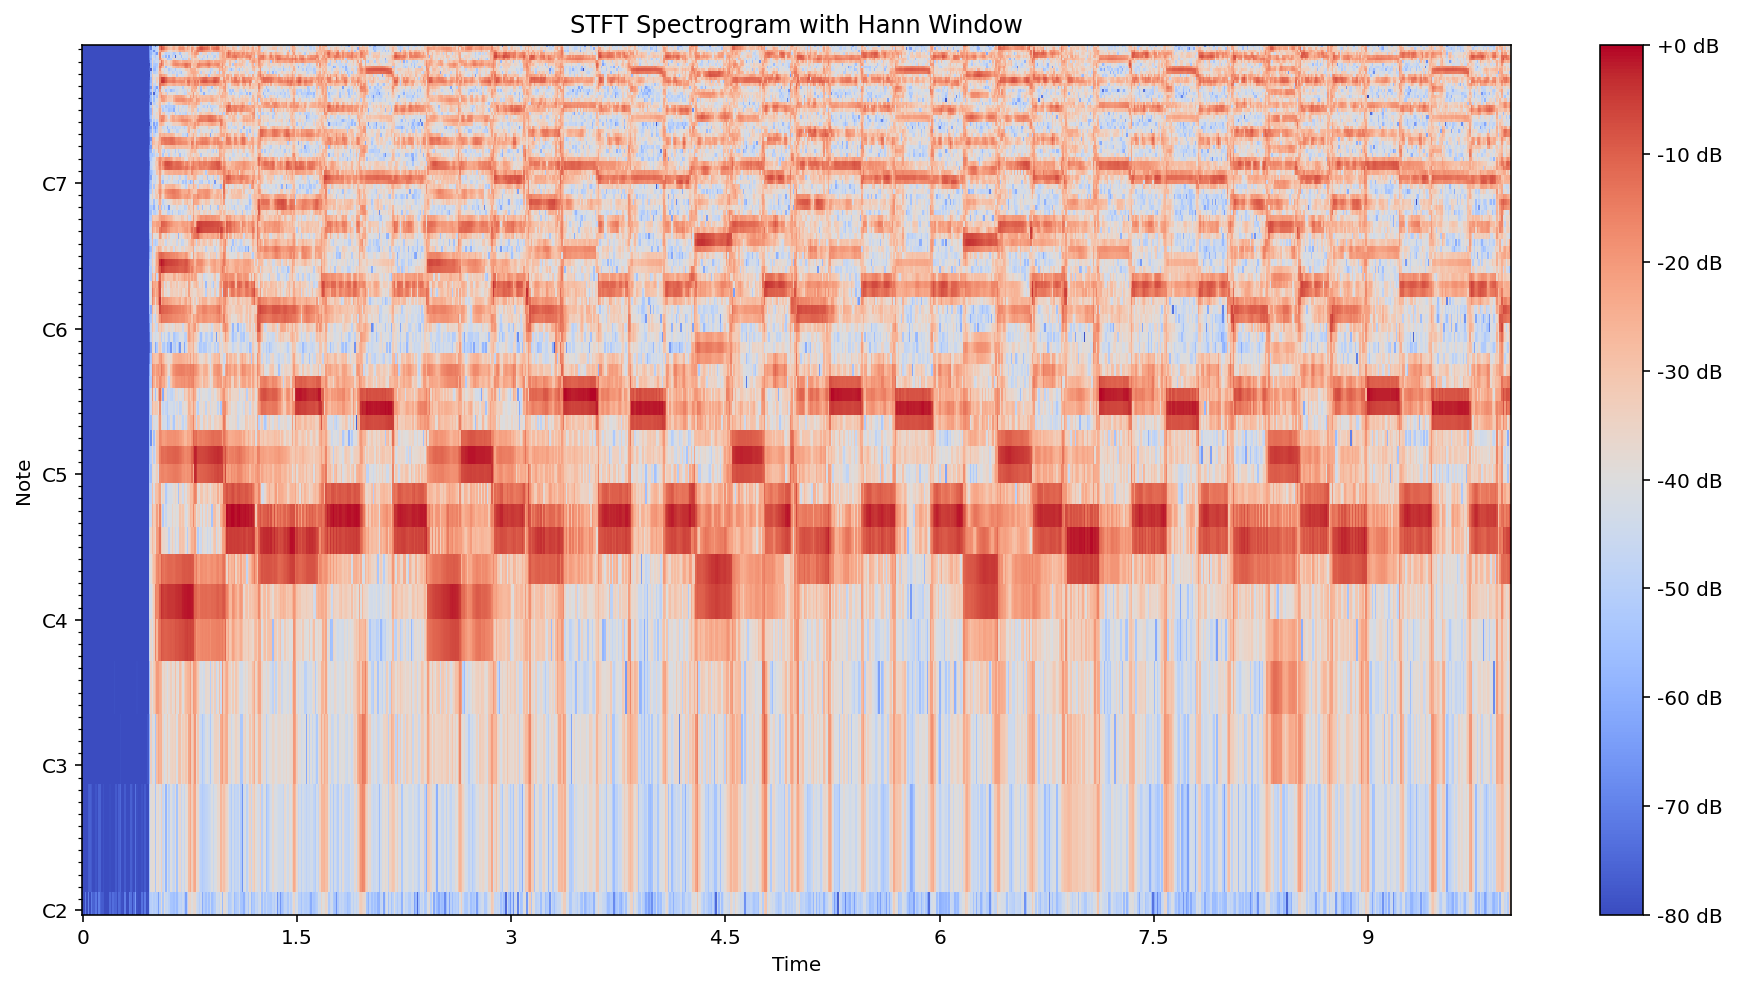

In [11]:
S = librosa.stft(data, n_fft=fft_window_len, hop_length=hop_length, window=scipy.signal.windows.hann)
Sdb = librosa.amplitude_to_db(np.abs(S), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(Sdb, sr=sampling_freq, hop_length=hop_length,
                               x_axis="time", y_axis="fft_note", ax=ax, cmap="coolwarm")
ax.set_title("STFT Spectrogram with Hann Window")
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.ylim(ylims)
plt.show()

## Music Primer

The above part of the notebook was pretty general--we were simply looking at converting a signal into the frequency domain using Fourier transforms.
The next parts of the notebook will require some understanding of how (Western) music is structured.
In the Western music system, notes that are an _octave_ apart are given the same letter.
A note that is an octave above another note has double the frequency.
Thus, we can see that musical notes are logarithmic in frequency, not linear.
Here are two notes an octave apart on the piano:

<img src="pictures/keyboard_octave.jpg" alt="Piano octave" width="600"/>

Another concept that is important for automatic music transcription is _overtones_.
Overtones are higher harmonics that occur when a note is played.
For example, when a guitar string is plucked, the fundamental frequency is heard most clearly, but higher frequencies are also present.
In fact, the timbre of an instrument is a result of the overtones present.
Here is a picture of overtones present for the top frequency.

<img src="pictures/overtones.png" alt="Overtones" width="300"/>


References:
- https://www.ams.jhu.edu/dan-mathofmusic/notes-intervals/

## Constant-Q Transform

The constant-Q transform (CQT) is similar to the STFT in the sense that it maps a signal into the frequency domain.
The main difference is that the CQT has filters logarithmically spaced in frequency as opposed to linear spaced filters in the STFT.
Formally, the width of the $k$th filter $\delta f_k$ is
\begin{equation}
    \delta f_k=2^{1/n} \cdot \delta f_{k-1} = \left(2^{1/n}\right)^k \cdot \delta f_0,
\end{equation}
where $n$ is the number of bins in an octave and $f_0$ is the first frequency bin.

This logarithmic property makes the CQT useful for music analysis.
Since the frequency bins are larger for lower frequencies and smaller for higher frequencies, the CQT helps distinguish higher pitches.
Note that this is similar to how we perceive pitch.

References:
- https://en.wikipedia.org/wiki/Constant-Q_transform

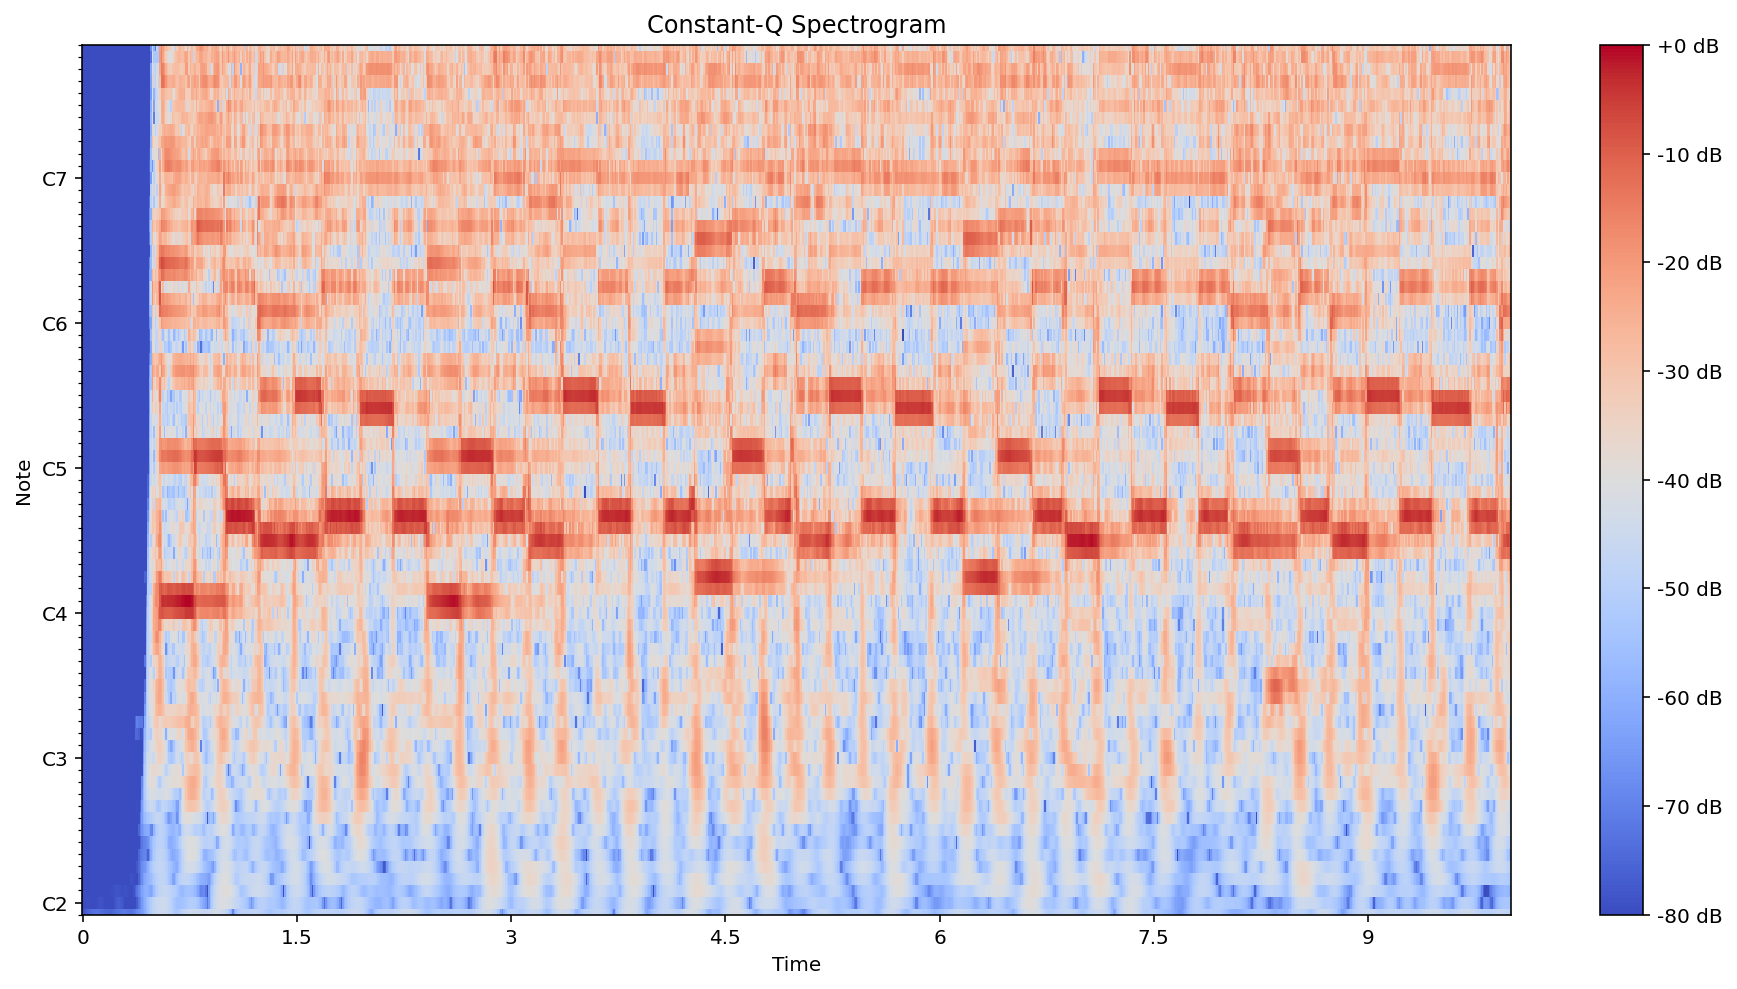

In [12]:
C = librosa.cqt(data, sr=sampling_freq, hop_length=hop_length, n_bins=n_bins)
fig, ax = plt.subplots()
Cdb = librosa.amplitude_to_db(np.abs(C), ref=np.max)
img = librosa.display.specshow(Cdb, sr=sampling_freq, hop_length=hop_length,
                               x_axis="time", y_axis="cqt_note", ax=ax, cmap="coolwarm")
ax.set_title("Constant-Q Spectrogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.ylim(ylims)
plt.show()

## Note Onset Detection

Now that we can detect pitches, we still need to know where each note starts and how long it lasts.
This task is called onset detection.
We cannot simply find note onsets by integrate or look for changes in the original signal in the time domain since audio signals are additive and oscillatory.
One method to perform onset detection is to look for changes in the spectrum of the signal over time.
We can do this by defining a function that calculates the change in the spectrum of the STFT.
Then, we look for peaks in this function.
This picture describes the process of calculating for note onsets:

<img src="pictures/onset.png" alt="Note onset detection" width="400"/>

References:
- https://librosa.org/doc/main/generated/librosa.onset.onset_detect.html#librosa.onset.onset_detect
- http://www.eecs.qmul.ac.uk/former/people/jbc/Documents/Bello-TSAP-2005.pdf

In [13]:
onset_strength = librosa.onset.onset_strength(y=data, sr=sampling_freq, hop_length=hop_length)
times = librosa.times_like(onset_strength, sr=sampling_freq)
onset_frames = librosa.onset.onset_detect(y=data, sr=sampling_freq, hop_length=hop_length,
                                          units='time', onset_envelope=onset_strength)

In [14]:
def filter_onset_frames(frames, raw_frames=[]):
    mean_diff = 0.1 
    #mean_diff = np.mean(np.diff(frames)) * 0.35
    if len(raw_frames) > 0:
        return raw_frames[[True] + list(np.diff(frames) > mean_diff)]
    return frames[[True] + list(np.diff(frames) > mean_diff)]

In [15]:
onset_frames = filter_onset_frames(onset_frames)

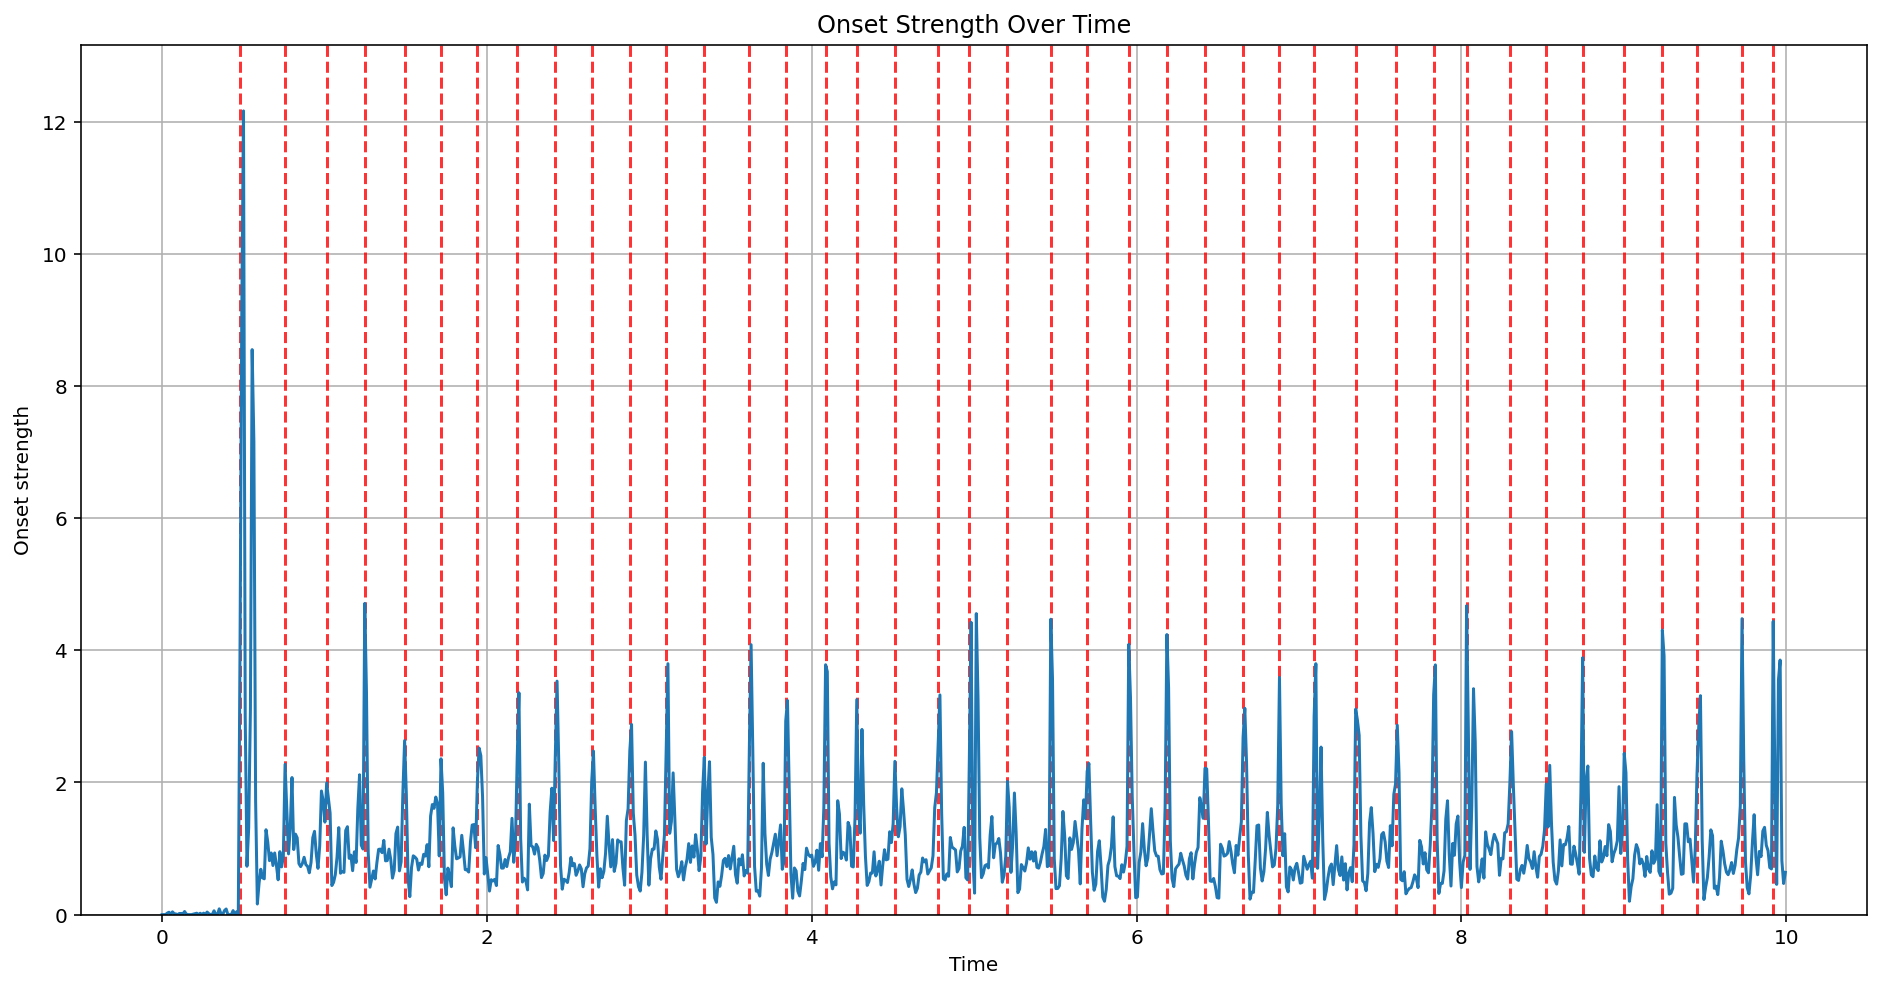

In [16]:
plt.plot(times, onset_strength)
plt.ylim(0, onset_strength.max() + 1)
plt.vlines(onset_frames, 0, onset_strength.max() + 1, color="r", alpha=0.8, linestyle="--")
plt.title("Onset Strength Over Time")
plt.xlabel("Time")
plt.ylabel("Onset strength")
plt.grid()
plt.show()

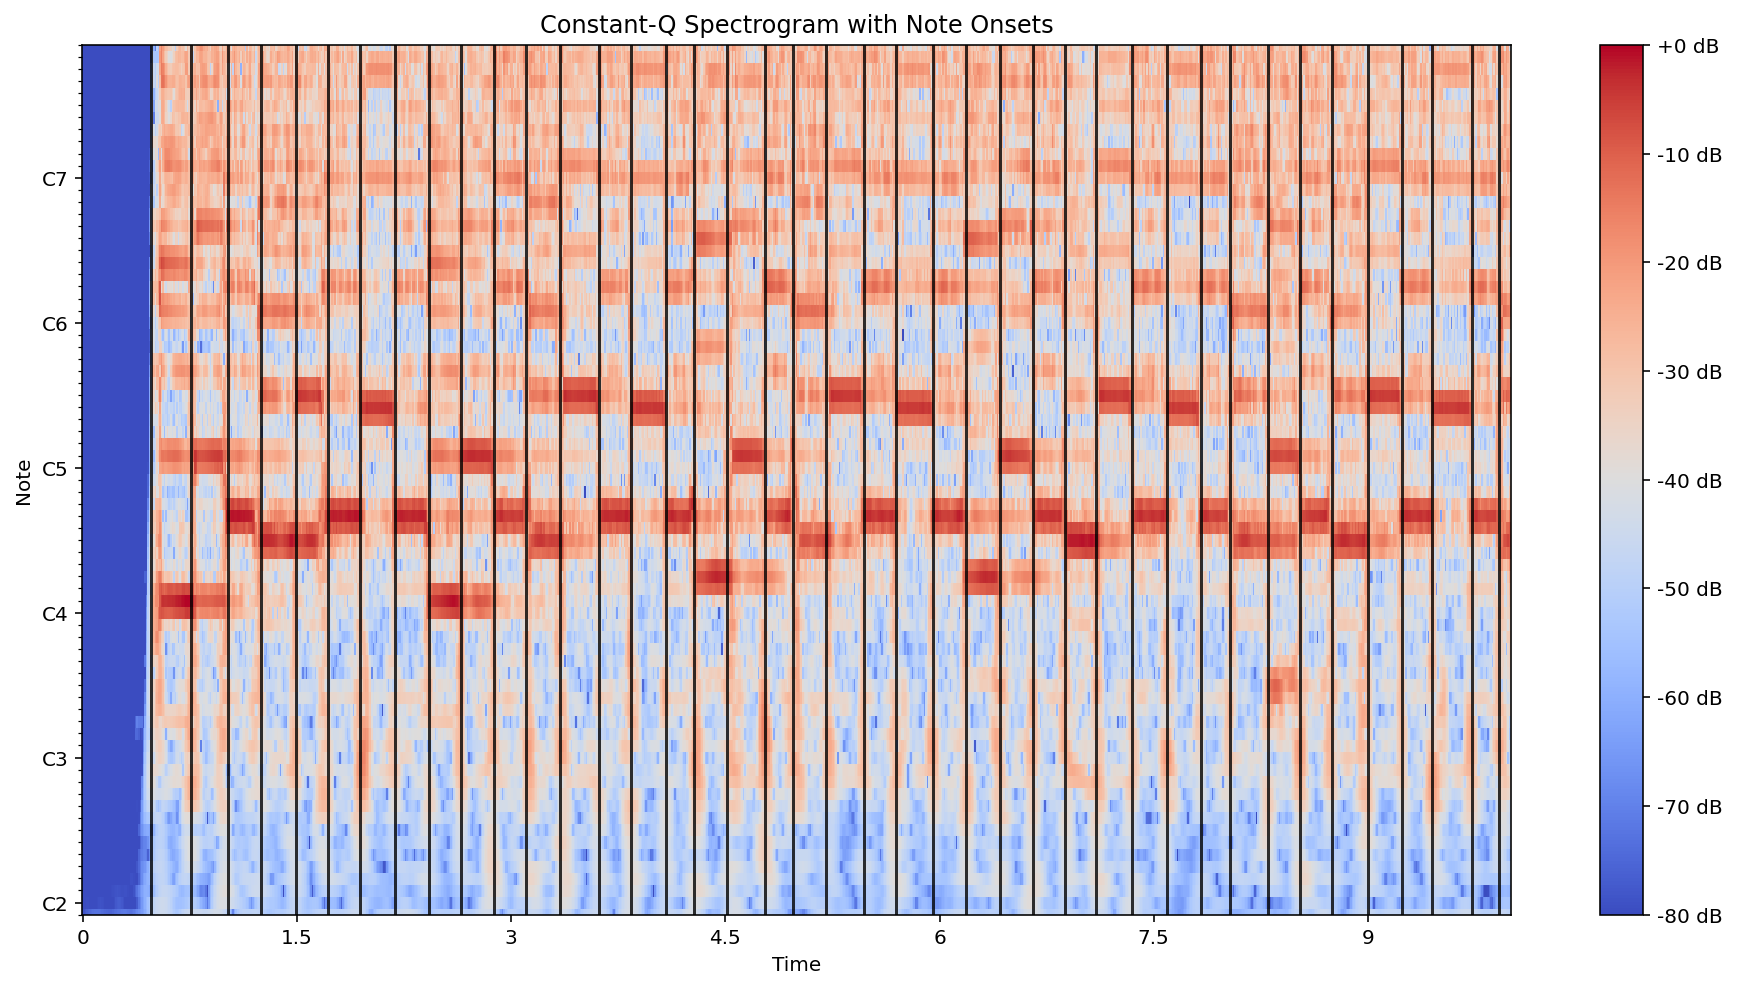

In [17]:
C = librosa.cqt(data, sr=sampling_freq, hop_length=hop_length, n_bins=n_bins)
fig, ax = plt.subplots()
Cdb = librosa.amplitude_to_db(np.abs(C), ref=np.max)
img = librosa.display.specshow(Cdb, sr=sampling_freq, hop_length=hop_length,
                               x_axis="time", y_axis="cqt_note", ax=ax, cmap="coolwarm")
ax.set_title("Constant-Q Spectrogram with Note Onsets")
plt.vlines(onset_frames, ax.get_ylim()[0], ax.get_ylim()[1], color="black", alpha=0.8, linestyle="-")
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.ylim(ylims)
plt.show()

Now, we extract the pitches and corresponding notes at each onset location.

In [18]:
onset_frames_raw = librosa.onset.onset_detect(y=data, sr=sampling_freq, hop_length=hop_length,
                                              units='frames', onset_envelope=onset_strength)
onset_frames_cpy = librosa.onset.onset_detect(y=data, sr=sampling_freq, hop_length=hop_length,
                                              units='time', onset_envelope=onset_strength)
onset_frames_raw = filter_onset_frames(onset_frames_cpy, onset_frames_raw)
assert(len(onset_frames) == len(onset_frames_raw))

In [19]:
middle_onset_frames = []
for i in range(len(onset_frames_raw) - 1):
    middle_onset_frames.append(int((onset_frames_raw[i] + onset_frames_raw[i + 1]) / 2))
middle_onset_frames.append(Cdb.shape[1] - 1)
assert(len(onset_frames) == len(middle_onset_frames))

In [20]:
freqs = librosa.cqt_frequencies(fmin=librosa.note_to_hz("C1"), n_bins=n_bins)

In [21]:
A4 = 440
C0 = A4 * 2 ** (-4.75)
FREQUENCY_RANGE = (15, 8000)
NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def get_note(freq):
    if freq > FREQUENCY_RANGE[1] or freq < FREQUENCY_RANGE[0]: return None
    h = round(12 * np.log2(freq / C0))
    octave = h // 12
    n = h % 12
    return NAMES[n] + str(octave)

In [22]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

def get_valid_freqs(dbs):
    scaled_dbs = (abs(dbs) - np.min(abs(dbs))) / np.max(abs(dbs))
    freqs = np.argwhere(scaled_dbs < 0.05).flatten()
    r = ranges(freqs)
    return [int(np.mean(x)) for x in r]
    return freqs

In [23]:
notes = []
note_lengths = []
for i in range(len(onset_frames) - 1):
    frame = middle_onset_frames[i]
    dbs = Cdb[:, frame]
    freq_ind = get_valid_freqs(dbs)[0]
    freq = freqs[freq_ind]
    note = get_note(freq)
    notes.append(note)
    note_lengths.append(onset_frames[i + 1] - onset_frames[i])

## Music Notation

Now that we have the notes and their durations, the next step is to output a score of the transcription.
This is useful for sharing the results in an easily accessible way.

In [24]:
bpm = librosa.beat.beat_track(y=data, sr=sampling_freq, hop_length=hop_length)[0]
print("BPM:", bpm)
len_of_beat = 60 / bpm  # In seconds
print("Beat length:", len_of_beat)

BPM: 127.8409090909091
Beat length: 0.4693333333333333


In [25]:
def estimate_note_length(note_length, len_of_beat):
    # Try whole note, half note, quarter note, eight note, and sixteenth note
    diffs = np.abs([note_length - len_of_beat * 4, note_length - len_of_beat * 2,
                    note_length - len_of_beat, note_length - len_of_beat / 2,
                    note_length - len_of_beat / 8])
    if np.argmin(diffs) == 0: return 1
    if np.argmin(diffs) == 1: return 2
    if np.argmin(diffs) == 2: return 4
    if np.argmin(diffs) == 3: return 8
    if np.argmin(diffs) == 4: return 16

In [26]:
note_notation_lengths = [estimate_note_length(x, len_of_beat) for x in note_lengths]

In [27]:
def convert_notes_and_lengths_to_abjad(notes, note_notation_lengths):
    assert(len(notes) == len(note_notation_lengths))
    
    def number_to_quotes(number):
        if number >= 3:
            return "'" * (number - 3)
        else:
            return "-" * (-1 * number + 3)

    def note_to_notation(note):
        n = note[0]
        if len(note) > 1 and note[1] == "#": return n + "s"
        if len(note) > 1 and note[1] == "b": return n + "f"
        else: return n

    ret = ""
    for i in range(len(notes)):
        note = notes[i].lower()
        note_len = note_notation_lengths[i]
        ret += note_to_notation(note[:-1]) + number_to_quotes(int(note[-1])) + str(note_len) + " "
    return ret

In [28]:
string = convert_notes_and_lengths_to_abjad(notes, note_notation_lengths)
staff = abjad.Staff(string)
lilypond_file = abjad.LilyPondFile(
    items=[
        r'\include "abjad.ily"',
        """#(set-default-paper-size "a5" 'portrait)""",
        """#(set-global-staff-size 16)""",
        """\header {{
            title = \markup {{ Automatic Transcription of {} }}
        }}""".format(filename.split("/")[-1]),
        """\layout {
            indent = 0
        }""",
        staff,
        
    ],
)
abjad.persist.as_png(lilypond_file, "./scores/score_output.png")

(('./scores/score_output.png',),
 0.012140750885009766,
 1.9608917236328125,
 False)

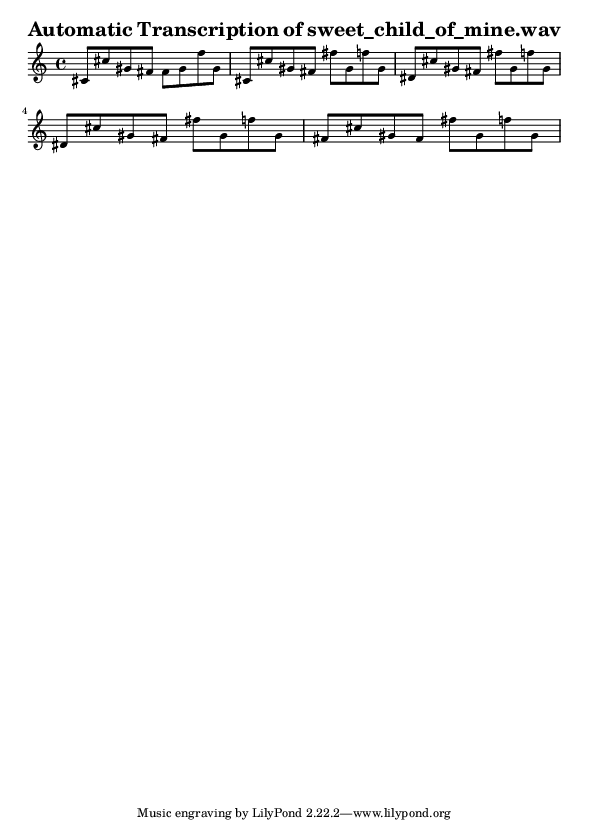

In [29]:
ipd.Image("./scores/score_output.png")

## Play Score

Furthermore, we include code to play the transcription.

In [30]:
def convert_notes_and_lengths_to_tiny(notes, note_notation_lengths):
    assert(len(notes) == len(note_notation_lengths))
    
    def number_to_quotes(number):
        return "'" * (number - 4)

    def notation(note):
        n = note[0]
        return n

    def accidental(note):
        if len(note) > 1 and note[1] == "#": return "#"
        if len(note) > 1 and note[1] == "b": return "-"
        else: return ""

    ret = ""
    for i in range(len(notes)):
        note = notes[i].lower()
        note_len = note_notation_lengths[i]
        ret += notation(note[:-1]) + number_to_quotes(int(note[-1])) + accidental(note[:-1]) + str(note_len) + " "
    return ret

In [31]:
string = convert_notes_and_lengths_to_tiny(notes, note_notation_lengths)
mm = music21.tempo.MetronomeMark(number=bpm)
stream = music21.stream.Stream()
stream.append(mm)
#stream.repeatAppend(music21.note.Note(quarterLength=1), 2)
#stream.append(music21.converter.parse("tinyNotation: 4/4 {}".format(string)))
for i in range(len(notes)):
    stream.append(music21.note.Note(notes[i], quarterLength=4 / note_notation_lengths[i]))
stream.show("text")

{0.0} <music21.tempo.MetronomeMark allegro moderato Quarter=127.8409090909091>
{0.0} <music21.note.Note C#>
{0.5} <music21.note.Note C#>
{1.0} <music21.note.Note G#>
{1.5} <music21.note.Note F#>
{2.0} <music21.note.Note F#>
{2.5} <music21.note.Note G#>
{3.0} <music21.note.Note F>
{3.5} <music21.note.Note G#>
{4.0} <music21.note.Note C#>
{4.5} <music21.note.Note C#>
{5.0} <music21.note.Note G#>
{5.5} <music21.note.Note F#>
{6.0} <music21.note.Note F#>
{6.5} <music21.note.Note G#>
{7.0} <music21.note.Note F>
{7.5} <music21.note.Note G#>
{8.0} <music21.note.Note D#>
{8.5} <music21.note.Note C#>
{9.0} <music21.note.Note G#>
{9.5} <music21.note.Note F#>
{10.0} <music21.note.Note F#>
{10.5} <music21.note.Note G#>
{11.0} <music21.note.Note F>
{11.5} <music21.note.Note G#>
{12.0} <music21.note.Note D#>
{12.5} <music21.note.Note C#>
{13.0} <music21.note.Note G#>
{13.5} <music21.note.Note F#>
{14.0} <music21.note.Note F#>
{14.5} <music21.note.Note G#>
{15.0} <music21.note.Note F>
{15.5} <music21

In [32]:
mf = music21.midi.translate.streamToMidiFile(stream)
filename_end = filename.split("/")[-1].split(".")[0]
mf.open('/Users/lucaspauker/Documents/physics_113/final_project/output/{}.mid'.format(filename_end), 'wb')
mf.write()
mf.close()

In [33]:
sp = music21.midi.realtime.StreamPlayer(stream)
sp.play()

# Polyphonic Music Transcription

So far, we have only tackled monophonic (one note at a time) transcription.
However, a much more challenging problem is polyphonic transcription (multiple notes played at once).
One approach to doing this is using non-negative matrix factorization (NMF).
The goal of NMF is to decompose a non-negative matrix $\mathbf{X}$ into a product of two non-negative matrices $\mathbf{W}$ and $\mathbf{H}$.
Therefore, NMF minimizes the cost function
\begin{equation}
    C=\| \mathbf{X} - \mathbf{W}\cdot\mathbf{H} \|_F,
\end{equation}
where $\|\cdot\|_F$ is the Frobenius norm.
Note that $C=0$ iff $\mathbf{X} = \mathbf{W}\cdot\mathbf{H}$.

Given a matrix of magnitude spectra $\mathbf{X}$ for a signal (i.e. the output of STFT), we calculate $\mathbf{W}\cdot\mathbf{H}\approx\mathbf{X}$ using NMF.
Analyzing $\mathbf{H}$ and $\mathbf{W}$, we see that the columns of $\mathbf{W}$ correspond to note frequencies and the rows of $\mathbf{H}$ correspond to the temporal activity of the notes.
From this, we can see that we have separated the temporal and frequency aspects of individual notes.
This allows us to parse out multiple notes being played at once.
Here is a picture of the output of NMF applied to a musical signal:

<img src="pictures/nmf.png" alt="NMF output" width="400"/>

We can see that, as described above, the columns of $\mathbf{W}$ correspond to note frequencies and the rows of $\mathbf{H}$ correspond to the temporal activity of the notes.

References:
- https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf
- https://www.ee.columbia.edu/~dpwe/e6820/papers/SmarB03-nmf.pdf

In [34]:
filename = "./sound_files/entertainer.wav"
sampling_freq, data = wavfile.read(filename)
print ("# channels: ", len(data.shape))
print ("sampling freq: ", sampling_freq)
if len(data.shape) == 2:
    data = data.sum(axis=1) / 2
n_seconds = 10
data = data[:sampling_freq * n_seconds]

# channels:  2
sampling freq:  48000


In [35]:
ipd.Audio(data, rate=sampling_freq)

In [36]:
S = np.abs(librosa.cqt(data, sr=sampling_freq, hop_length=hop_length, n_bins=n_bins))
Cdb = librosa.amplitude_to_db(S, ref=np.max)
comps, acts = librosa.decompose.decompose(S, n_components=32, sort=True, max_iter=1000)
print("Shape of components matrix:", comps.shape)
print("Shape of activations matrix:", acts.shape)

/Users/lucaspauker/anaconda3/envs/phys113/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


Shape of components matrix: (100, 32)
Shape of activations matrix: (32, 938)


/Users/lucaspauker/anaconda3/envs/phys113/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


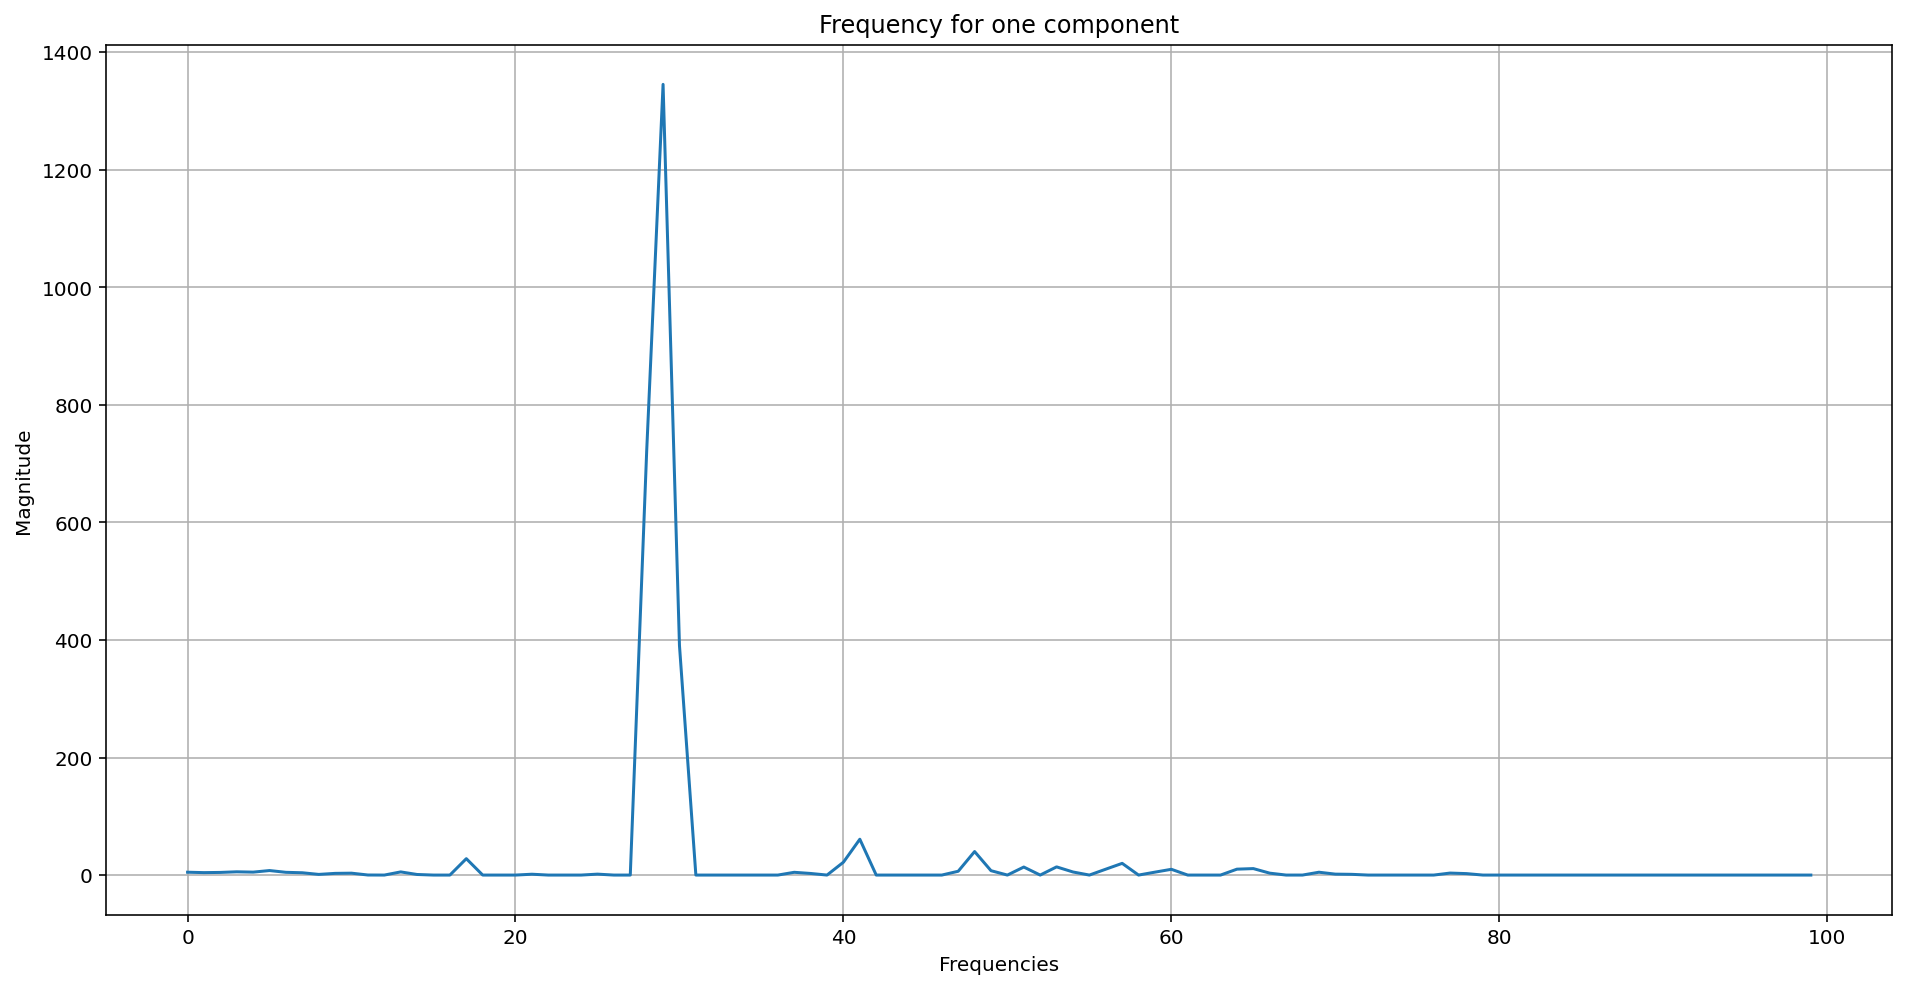

In [37]:
plt.plot(comps[:, 10])
plt.title("Frequency for one component")
plt.ylabel("Magnitude")
plt.xlabel("Frequencies")
plt.grid()
plt.show()

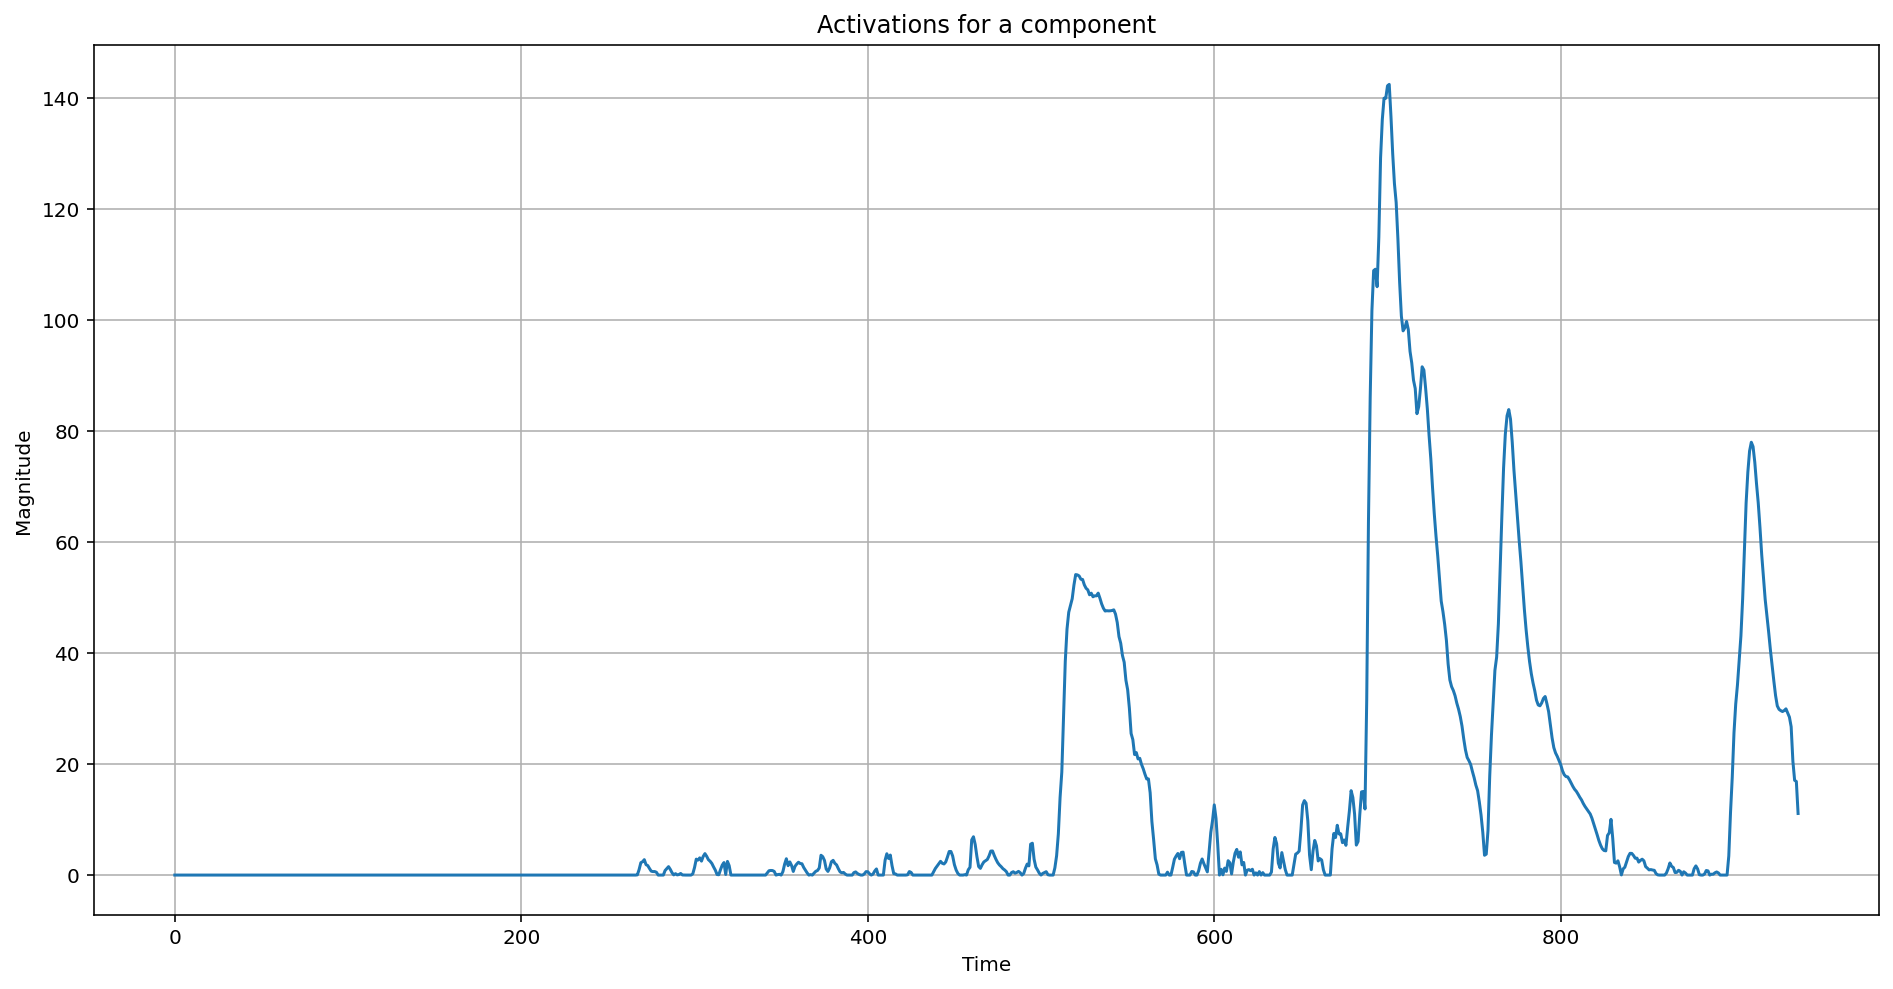

In [38]:
plt.plot(acts[10])
plt.title("Activations for a component")
plt.ylabel("Magnitude")
plt.xlabel("Time")
plt.grid()
plt.show()

/Users/lucaspauker/anaconda3/envs/phys113/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


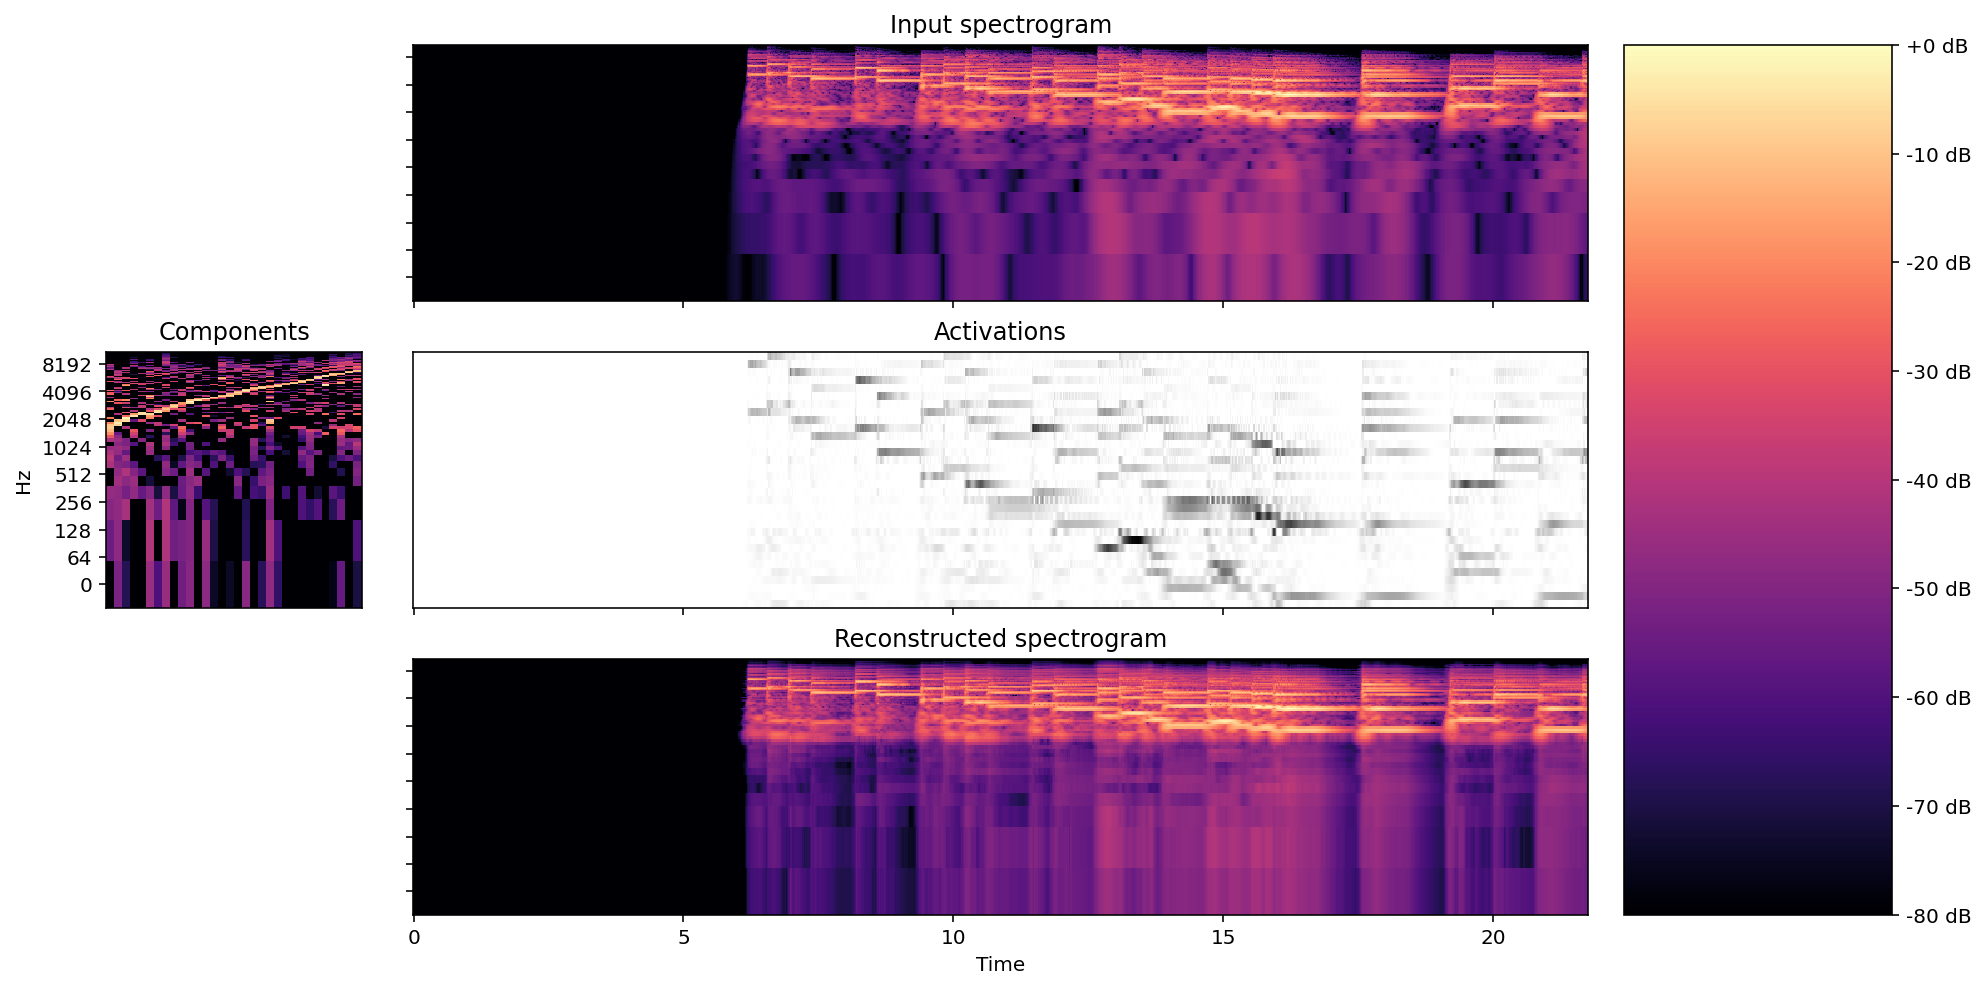

In [39]:
layout = [list(".AAAA"), list("BCCCC"), list(".DDDD")]
fig, ax = plt.subplot_mosaic(layout, constrained_layout=True)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax['A'])
ax['A'].set(title='Input spectrogram')
ax['A'].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(comps, ref=np.max),
                         y_axis='log', ax=ax['B'])
ax['B'].set(title='Components')
ax['B'].label_outer()
ax['B'].sharey(ax['A'])
librosa.display.specshow(acts, x_axis='time', ax=ax['C'], cmap='gray_r')
ax['C'].set(ylabel='Components', title='Activations')
ax['C'].sharex(ax['A'])
ax['C'].label_outer()
S_approx = comps.dot(acts)
img = librosa.display.specshow(librosa.amplitude_to_db(S_approx, ref=np.max),
                               y_axis='log', x_axis='time', ax=ax['D'])
ax['D'].set(title='Reconstructed spectrogram')
ax['D'].sharex(ax['A'])
ax['D'].sharey(ax['A'])
ax['D'].label_outer()
fig.colorbar(img, ax=list(ax.values()), format="%+2.f dB")
plt.show()

In [40]:
onset_strength = librosa.onset.onset_strength(y=data, sr=sampling_freq, hop_length=hop_length)
times = librosa.times_like(onset_strength, sr=sampling_freq)
onset_frames = librosa.onset.onset_detect(y=data, sr=sampling_freq, hop_length=hop_length,
                                          units='time', onset_envelope=onset_strength)
onset_frames_raw = librosa.onset.onset_detect(y=data, sr=sampling_freq, hop_length=hop_length,
                                              units='frames', onset_envelope=onset_strength)
onset_frames_cpy = librosa.onset.onset_detect(y=data, sr=sampling_freq, hop_length=hop_length,
                                              units='time', onset_envelope=onset_strength)
onset_frames_raw = filter_onset_frames(onset_frames_cpy, onset_frames_raw)
assert(len(onset_frames) == len(onset_frames_raw))

middle_onset_frames = []
for i in range(len(onset_frames_raw) - 1):
    middle_onset_frames.append(int((onset_frames_raw[i] + onset_frames_raw[i + 1]) / 2))
middle_onset_frames.append(Cdb.shape[1] - 1)
assert(len(onset_frames) == len(middle_onset_frames))

In [41]:
notes = []
note_lengths = []
for i in range(len(onset_frames) - 1):
    frame = middle_onset_frames[i]
    dbs = Cdb[:, frame]
    freq_ind = get_valid_freqs(dbs)[0]
    freq = freqs[freq_ind]
    note = get_note(freq)
    notes.append(note)
    note_lengths.append(onset_frames[i + 1] - onset_frames[i])
note_notation_lengths = [estimate_note_length(x, len_of_beat) for x in note_lengths]

In [42]:
freqs = librosa.cqt_frequencies(fmin=librosa.note_to_hz("C1"), n_bins=n_bins)
comp_freqs = []
for i in range(comps.shape[1]):
    comp_freqs.append(freqs[np.argmax(comps[:, i])])
comp_notes = [get_note(x) for x in comp_freqs]

In [43]:
print(comp_notes)

['D#2', 'F2', 'G2', 'G#2', 'A2', 'A2', 'A#2', 'C3', 'D3', 'E3', 'F3', 'F#3', 'G3', 'G#3', 'A3', 'A#3', 'C4', 'D4', 'E4', 'F4', 'F#4', 'G4', 'A4', 'A#4', 'C5', 'D5', 'F5', 'G5', 'A5', 'A#5', 'C6', 'D6']


In [44]:
n_voices = 2

In [45]:
notes = []
for frame in middle_onset_frames[:-1]:
    notes.append(np.array(comp_notes)[np.sort(np.argpartition(acts[:, frame], -1 * n_voices)[-1 * n_voices:])])
notes = np.array(notes)

In [46]:
string_1 = convert_notes_and_lengths_to_abjad(notes[:, 0], note_notation_lengths)
string_2 = convert_notes_and_lengths_to_abjad(notes[:, 1], note_notation_lengths)
voice_1 = abjad.Voice(string_1, name="Voice_1")
voice_2 = abjad.Voice(string_2, name="Voice_2")
staff_1 = abjad.Staff(string_1, name="Staff_1")
staff_2 = abjad.Staff(string_2, name="Staff_2")
piano_staff = abjad.StaffGroup(
    [staff_1, staff_2],
    lilypond_type="PianoStaff",
    name="PianoStaff",
)
lilypond_file = abjad.LilyPondFile(
    items=[
        r'\include "abjad.ily"',
        """#(set-default-paper-size "a5" 'portrait)""",
        """#(set-global-staff-size 16)""",
        """\header {{
            title = \markup {{ Automatic Transcription of {} }}
        }}""".format(filename.split("/")[-1]),
        """\layout {
            indent = 0
        }""",
        piano_staff,
        
    ],
)
abjad.persist.as_png(lilypond_file, "./scores/score_output.png")

(('./scores/score_output.png',), 0.00997781753540039, 2.618115186691284, False)

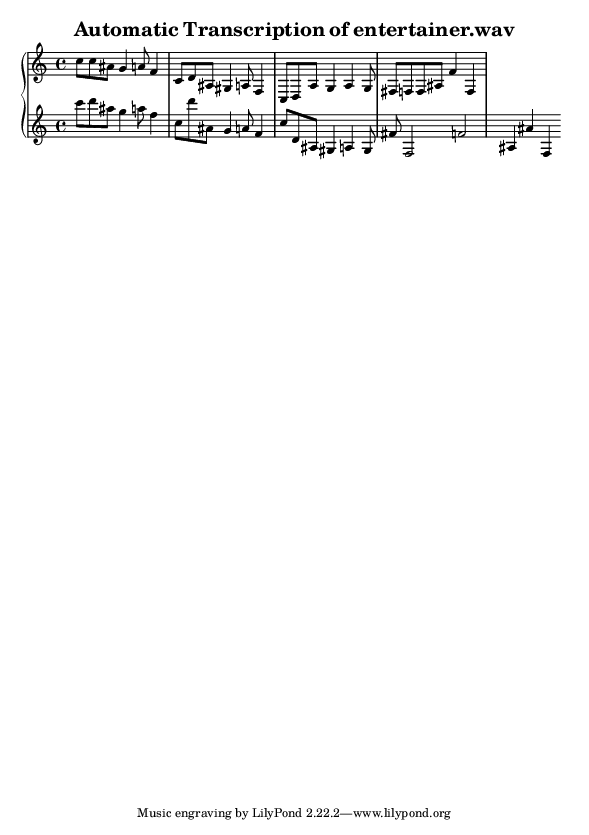

In [47]:
ipd.Image("./scores/score_output.png")

In [48]:
#string_1 = convert_notes_and_lengths_to_tiny(notes[:, 0], note_notation_lengths)
#string_2 = convert_notes_and_lengths_to_tiny(notes[:, 1], note_notation_lengths)
mm = music21.tempo.MetronomeMark(number=bpm)
stream = music21.stream.Stream()
stream.append(mm)
#stream.repeatAppend(music21.note.Note(quarterLength=1), 2)
#stream.append(music21.converter.parse("tinyNotation: 4/4 {}".format(string)))
for i in range(len(notes)):
    c = music21.chord.Chord(" ".join(notes[i]), quarterLength=4 / note_notation_lengths[i])
    stream.append(c)
stream.show("text")

{0.0} <music21.tempo.MetronomeMark allegro moderato Quarter=127.8409090909091>
{0.0} <music21.chord.Chord C5 C6>
{0.5} <music21.chord.Chord C5 D6>
{1.0} <music21.chord.Chord A#4 A#5>
{1.5} <music21.chord.Chord G4 G5>
{2.5} <music21.chord.Chord A4 A5>
{3.0} <music21.chord.Chord F4 F5>
{4.0} <music21.chord.Chord C4 C5>
{4.5} <music21.chord.Chord D4 D6>
{5.0} <music21.chord.Chord A#3 A#4>
{5.5} <music21.chord.Chord G#3 G4>
{6.5} <music21.chord.Chord A3 A4>
{7.0} <music21.chord.Chord F3 F4>
{8.0} <music21.chord.Chord C3 C5>
{8.5} <music21.chord.Chord D3 D4>
{9.0} <music21.chord.Chord A2 A#2>
{9.5} <music21.chord.Chord G3 G#3>
{10.5} <music21.chord.Chord A2 A2>
{11.0} <music21.chord.Chord G3 G#3>
{11.5} <music21.chord.Chord F#3 F#4>
{12.0} <music21.chord.Chord F2 F3>
{14.0} <music21.chord.Chord F2 F4>
{16.0} <music21.chord.Chord A#2 A#3>
{17.0} <music21.chord.Chord F4 A#4>
{18.0} <music21.chord.Chord F2 F3>


In [49]:
sp = music21.midi.realtime.StreamPlayer(stream)
sp.play()